In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
# ##################################################################
# #Find right model dir
# ##################################################################

# rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
#           'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
#           'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_trains_str = '_'.join(rule_trains)

# rnn_type = 'LeakyRNN'
# activation = 'softplus'
# w_init = 'diag'
# n_tasks = str(len(rule_trains))
# n_rnn = str(256)
# l2w = -6
# l2h = -6
# l1w = 0
# l1h = 0
# seed = '1'
# lr = -7
# net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
# data_folder = 'data/rnn/multitask/stepnet/lr'
# m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [14]:
##########
# Set examples by hand for each
##########
# activation = 'tanh'
# w_rec_coeff  = 1
# seed = '0'
# lr = -8
# ##########
activation = 'retanh'
w_rec_coeff  = 8/10
seed = '1'
lr = -6
cat_q_thresh = .00000001
contin_q_thresh = .000001
##########
# activation = 'softplus'
# w_rec_coeff  = 8/10
# seed = '0'
# lr = -6
##########

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
w_init = 'diag'
ruleset = 'all'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
sigma_rec = 1/20
sigma_x = 2/20

data_folder_all = 'data/rnn/multitask/stepnet/'

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)
net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

dir_specific_all = os.path.join('final1',ruleset,rnn_type,activation,
    w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2)

m = os.path.join(p,'data','rnn','multitask',net,dir_specific_all,str(seed))


In [15]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','supp','supp_interp_delay',activation)
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [16]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.c

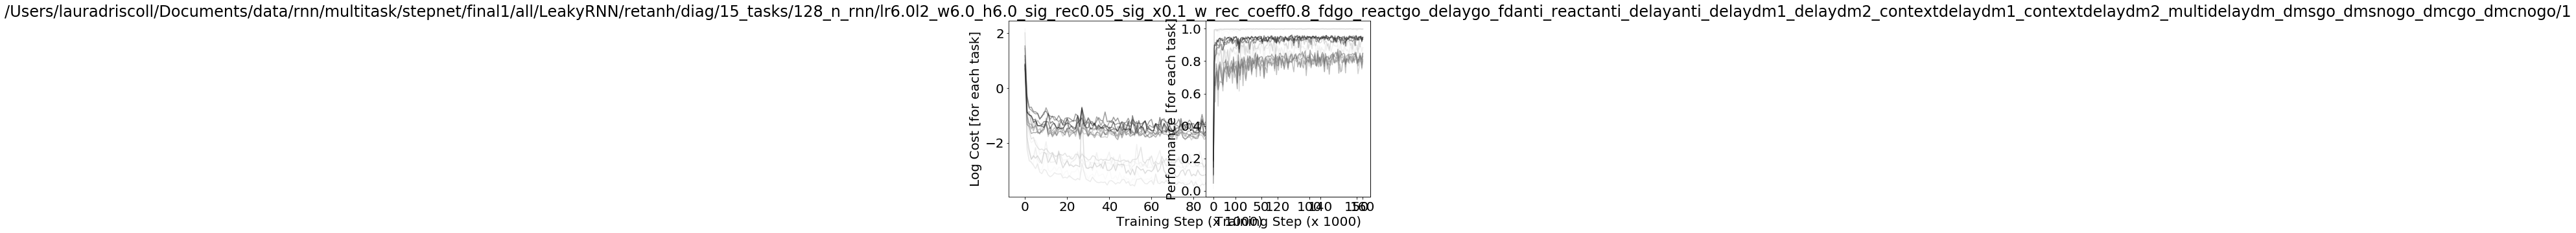

In [17]:
fig = plt.figure(figsize=(10, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')
task_list = hparams['rule_trains']

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    
    ax1 = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)

    ax2 = fig.add_subplot(1,2,2)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)

ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')    
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
plt.title(m)
plt.show()    

In [18]:
def remove_ax_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
def label_categories(ax,rule):
    
    if 'dmc' in rule:
        plt.text(0.0, 0.05, 'Category 1', color='w', transform=ax.transAxes,fontsize = 12)
        plt.text(0.5, 0.05, 'Category 2', color='w', transform=ax.transAxes,fontsize = 12)
        
def Xcorr_trials(m,trial,x,epoch):
    
    t1 = trial.epochs[epoch][1]-5
    plt.imshow((np.corrcoef(x[:,trial_set,t1].T)))
    plt.title('time = '+str(t1))
    plt.ylabel('trial number')
    plt.xlabel('trial number')
#     label_categories(ax,rule)
    remove_ax_lines(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
def Xcorr_time(m,trial,x,trial_num = 0):
    
    plt.imshow((np.corrcoef(x[:,trial_num,:].T)))
    offset = 5
    al = .5

    for e in trial.epochs.keys():
        plt.plot([trial.epochs[e][0],trial.epochs[e][0]],[0,np.shape(x)[2]-1],'-w')
        plt.plot([0,np.shape(x)[2]-1],[trial.epochs[e][0],trial.epochs[e][0]],'-w')
        
        if e is not 'fix1':
            plt.text(trial.epochs[e][0]-2,-5,e[:-1]+ ' onset',rotation = 90,ha = 'left', va='bottom')

    plt.title('trial = '+str(trial_num),x = -.15,y = 1.05)
    plt.ylabel('time in trial')
    plt.xlabel('time in trial')
    remove_ax_lines(ax)

In [19]:
def plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 3, cat = False, labels=False,
                      mod_task1 = 'either',mod_task2 = 'either',first_stim = True):
    
    color_set = ['dimgray','gainsboro','dimgray','gainsboro']
    grad_cmap = plt.get_cmap('hsv')
    n_trials = np.shape(trial1.x)[1]+np.shape(trial2.x)[1]
    
    n_trials_show = 20
    trial_set = range(0,n_trials,int(n_trials/n_trials_show))
    
    if mod_task1 is 'either':
        if first_stim == True:
            stim_locs1 = np.min(trial1.stim_locs[:,[0,2]],axis=1)
        else:
            stim_locs1 = np.min(trial1.stim_locs[:,[1,3]],axis=1)
    elif mod_task1==1:
        if first_stim == True:
            stim_locs1 = trial1.stim_locs[:,0]
        else:
            stim_locs1 = trial1.stim_locs[:,1]
    elif mod_task1==2:
        if first_stim == True:
            stim_locs1 = trial1.stim_locs[:,2]
        else:
            stim_locs1 = trial1.stim_locs[:,3]
                     
    if mod_task2 is 'either':
        if first_stim == True:
            stim_locs2 = np.min(trial2.stim_locs[:,[0,2]],axis=1)
        else:
            stim_locs2 = np.min(trial2.stim_locs[:,[1,3]],axis=1)
    elif mod_task1==1:
        if first_stim == True:
            stim_locs2 = trial2.stim_locs[:,0]
        else:
            stim_locs2 = trial2.stim_locs[:,1]
    elif mod_task1==2:
        if first_stim == True:
            stim_locs2 = trial2.stim_locs[:,2]
        else:
            stim_locs2 = trial2.stim_locs[:,3]
    
    stim_locs = np.concatenate((stim_locs1,stim_locs2))
    task_binary = np.concatenate((np.ones(np.shape(trial1.x)[1]),np.zeros(np.shape(trial2.x)[1])))
    response_binary = [((task_binary[x]==0) & (stim_locs[x]>np.pi)) or ((task_binary[x]==1) & (stim_locs[x]<np.pi))
                       for x in range(len(stim_locs))]
    
    for ti in range(len(trial_set)):
        
        trial_num = trial_set[ti]
        stim_color = grad_cmap(stim_locs[trial_num]/(2*np.pi))
        task_color = color_set[ti<int(len(trial_set)/2)]
        response_color = color_set[2+response_binary[trial_num]]
        
        if 'y' in which_axes:
            
            if cat==True:
                ax.plot(ti,-ms*.25,'s',color = response_color,markersize = ms)
            else:
                ax.plot(ti,-ms*.25,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.5,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.75,'s',color = task_color,markersize = ms)
            
        if 'x' in which_axes:
            
            if cat==True:
                ax.plot(-ms*.25,ti,'s',color = response_color,markersize = ms)
            else:
                ax.plot(-ms*.25,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.5,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.75,ti,'s',color = task_color,markersize = ms)
            
    if labels == True:

        if cat==True:
            plt.text(len(trial_set),-ms*.15,'respond to <$\pi$')
        else:
            plt.text(len(trial_set),-ms*.15,'response angle')
        plt.text(len(trial_set),-ms*.4,'stimulus angle')
        plt.text(len(trial_set),-ms*.65,'task')

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.c

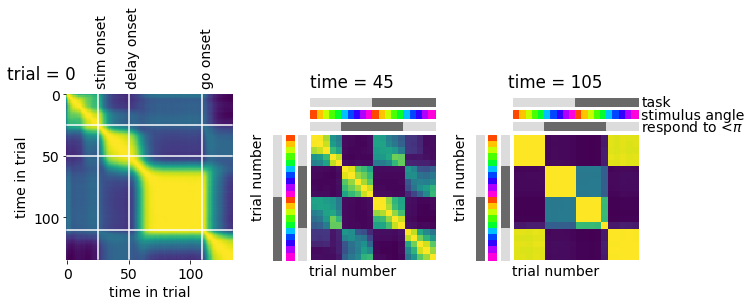

In [20]:
plt.rcParams.update({'font.size': 14})
n_trials_show = 20

cat_set = [13,14]
ri_set = cat_set
rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

_,x1 = gen_X_from_model_dir(m,trial1)
_,x2 = gen_X_from_model_dir(m,trial2)
x12 = np.concatenate((x1,x2),axis = 1)

fig = plt.figure(figsize=(12,4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,4,1)
trial_set = range(0,np.shape(x1)[1],int(np.shape(x1)[1]/n_trials_show))
Xcorr_time(m,trial1,x1,trial_num = 0)

ax = fig.add_subplot(1,4,2)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'stim1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = True)

ax = fig.add_subplot(1,4,3)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'delay1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = True, labels=True)

fig_spec_fldr = os.path.join(figpath,'X_corr_trials')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])     
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.png'))

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.c

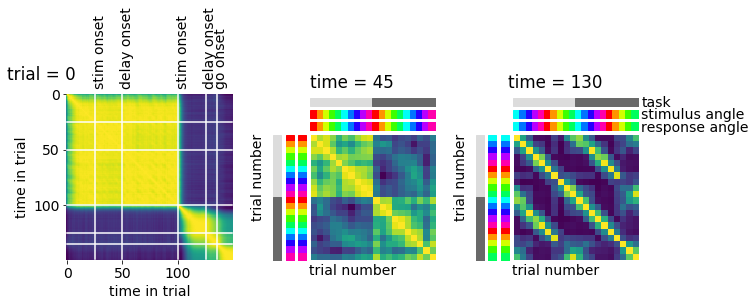

In [21]:
n_trials_show = 20

contin_set = [6,7]
ri_set = contin_set
rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

_,x1 = gen_X_from_model_dir(m,trial1)
_,x2 = gen_X_from_model_dir(m,trial2)
x12 = np.concatenate((x1,x2),axis = 1)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))

fig = plt.figure(figsize=(12,4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,4,1)
trial_set = range(0,np.shape(x1)[1],int(np.shape(x1)[1]/n_trials_show))
Xcorr_time(m,trial1,x1,trial_num = 0)

ax = fig.add_subplot(1,4,2)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'stim1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = False,
                      mod_task1 = 1,mod_task2 = 2,first_stim = True)

ax = fig.add_subplot(1,4,3)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'delay2')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = False, labels=True,
                      mod_task1 = 1,mod_task2 = 2,first_stim = False)

fig_spec_fldr = os.path.join(figpath,'X_corr_trials')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])     
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.png'))

In [22]:
# from tools_lnd import gen_mov_trial_set, make_D_use

# q_thresh = 1e-5
# offset = 0
# t_set = [offset, offset]
# trial_num = [int(offset/4), int(offset/4)]
# rule_axs = 0
# rule_set = [13,14]
# trial_set = gen_mov_trial_set(m,rule_set)
# epoch_set = ['delay1','delay1']
# epoch = epoch_set[rule_axs]
# rule = rules_dict['all'][rule_set[rule_axs]]
# ti = trial_num[rule_axs]

# rule1 = rules_dict['all'][rule_set[0]]
# rule2 = rules_dict['all'][rule_set[1]]
# rule_str = [rule1,rule2]

# ax_labels = 'pca_fp'
# D_fix = make_D_use(m,rule,'delay1',ti,ax_labels)
# D_use = D_fix


# interp = True
# fig_size = 6

# epoch_set = ['delay1','delay1']
# script_name = 'interp_tasks_small_init_mov'

# ax_use = [2,0,1]
# D_rotate = D_use[:,ax_use]
# ax_labels = [ax_labels_master[alm] for alm in ax_use]

# ax_labels[0] = r"Rule Input $\alpha$"
# # bifurc(m,D_rotate,rule_set,epoch_set,script_name = script_name,q_thresh = q_thresh, rule_axs = rule_axs, 
# #        color_stim = True, fig_size = fig_size,fontsize = 16, figpath = figpath, ruleset = ruleset,
# #        ax_labels = ax_labels, stability_thresh = 1.05, lims = [])

# plot_bifurc_ends(m, D_rotate, rule_set, epoch_set, script_name, lims = [], fac_mult_lims = 2,
#                  stability_thresh = 1.05, fp_first = False, figpath = figpath, ruleset = ruleset)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.c

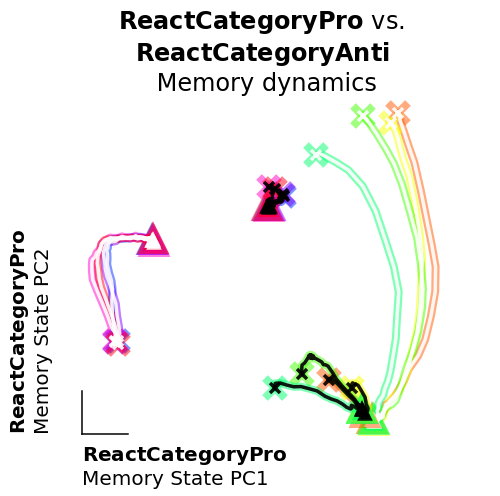

In [23]:
########## X TASK ###########

from tools_lnd import make_D_use, interp2d

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = cat_set
epoch_set = ['delay1','delay1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = False

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

# interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
#          interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
#          fig_size = 8, color_stim = False, figpath = figpath, plot_zero_plane = False, lil_axes = False, 
#          ruleset = 'all',ax_labels = axs) 
# ruleset = 'fig2_interp_delay',ax_labels = ['CategoryNogo PC1','CategoryNogo PC2','CategoryNogo PC3'],
#,plot_zero_plane = False

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
         interp = interp,q_thresh = .0000001,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
        figpath = figpath,fig_size = 7, color_stim = False,stability_thresh = 1.05,fp_first = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/retanh/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.c

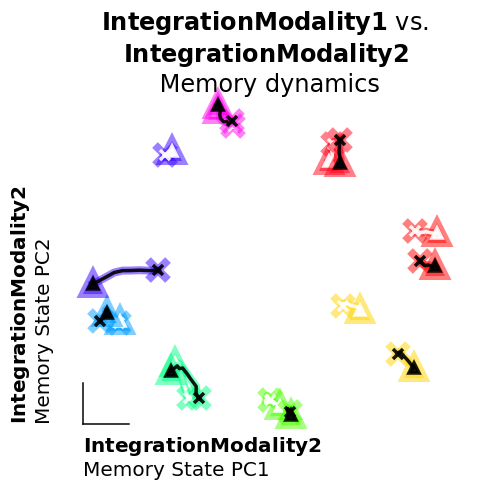

In [24]:
########## X TASK ###########

from tools_lnd import interp2d, make_D_use

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [6,7]
epoch_set = ['delay2','delay2']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = False

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

rule_axs = 1
epoch = 'delay2'#epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

# interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
#          interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
#          fig_size = 8, color_stim = False, figpath = figpath, plot_zero_plane = False, lil_axes = False, 
#          ruleset = 'all',ax_labels = ax_labels_master) 
# ruleset = 'fig2_interp_delay',ax_labels = ['CategoryNogo PC1','CategoryNogo PC2','CategoryNogo PC3'],
#,plot_zero_plane = False

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
         interp = interp,q_thresh = .0001,rule_axs = rule_axs, plot_unstable = True, n_skip_interps=1,
        figpath = figpath,fig_size = 7, color_stim = False, stability_thresh = 2)

In [ ]:
from network import get_perf
from tools_lnd import same_mov_inds
def init_from_other_task(m,ri_set,init_from):

    rule1 = rules_dict['all'][ri_set[0]]
    rule2 = rules_dict['all'][ri_set[1]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
    trial2 = same_mov_inds(trial1, trial2) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    trial_set = [trial1,trial2]
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp

    epoch = 'go1'
    B = np.shape(trial1.x)[1]
    N = hparams['n_rnn']

    _,h = gen_X_from_model_dir(m,trial_set[init_from])
    T1_inds = get_T_inds(trial1,epoch)
    T2_inds = get_T_inds(trial2,epoch)

    y_hat = np.zeros((len(T1_inds),B,3))
    for ti in range(B):

        h0 = h[:,ti,T2_inds[0]-2]
        x_t = trial1.x[T1_inds[1:],ti,:]
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
        y_hat[:,ti,:] = out_affine(params, h_t.T).T

    y_loc = trial1.y_loc[T1_inds,:]
    return get_perf(y_hat, y_loc)

In [ ]:
p_ins = {}
p_ins['No Perturb'] = {}
p_ins['No Perturb']['ri_set'] = [6,7]
p_ins['No Perturb']['init'] = 0
p_ins['No Perturb']['id'] = 0

p_ins['Init from Shared Motif'] = {}
p_ins['Init from Shared Motif']['ri_set'] = [6,7]
p_ins['Init from Shared Motif']['init'] = 1
p_ins['Init from Shared Motif']['id'] = 1

p_ins['Init from Other Motif'] = {}
p_ins['Init from Other Motif']['ri_set'] = [6,14]
p_ins['Init from Other Motif']['init'] = 1
p_ins['Init from Other Motif']['id'] = 2

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/mod

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/mod

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) d

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmc

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) d

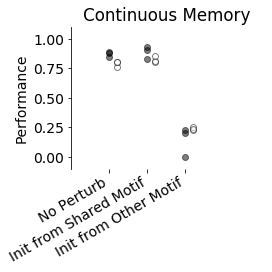

In [16]:
plt.rcParams.update({'font.size': 14})
n_rnn = str(128)
w_rec_coeff  = 8/10
sigma_rec = 1/20
data_folder_all = 'data/rnn/multitask/stepnet/'

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

for rnn_type in ['LeakyRNN']:
        for w_init in ['diag','randgauss']:#
            for seed in ['0','1','2']:
                if (activation=='tanh') & (rnn_type=='LeakyRNN'):
                    w_rec_coeff  = 1
                    lr = -8
                else:
                    w_rec_coeff  = 8/10
                    lr = -6
                    
                if w_init=='diag':
                    c = 'k'
                    x_off = 0
                else:
                    c = 'w'
                    x_off = 0.2

                net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)
                net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                dir_specific_all = os.path.join('final1',ruleset,rnn_type,activation,
                    w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2)

                m = os.path.join(p,'data','rnn','multitask',net,dir_specific_all,str(seed))
        
                for key_i in range(len(p_ins.keys())):
                    key = p_ins.keys()[key_i]
                    perf = init_from_other_task(m,p_ins[key]['ri_set'],p_ins[key]['init'])

                    plt.plot(p_ins[key]['id']+x_off,np.mean(perf),'ok',markerfacecolor = c,alpha = .5)

plt.ylabel('Performance')
tit = 'Continuous Memory'
plt.title(tit)
plt.xticks(range(len(p_ins.keys())),['No Perturb','Init from Shared Motif','Init from Other Motif'],
           rotation = 30,ha = 'right')
plt.ylim([-.1,1.1])
plt.xlim([-1,len(p_ins.keys())+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig_spec_fldr = os.path.join(figpath,'Init_X_motifs')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = tit   
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.png'))

In [17]:
p_ins = {}
p_ins['No Perturb'] = {}
p_ins['No Perturb']['ri_set'] = [13,14]
p_ins['No Perturb']['init'] = 0
p_ins['No Perturb']['id'] = 0

p_ins['Init from Shared Motif'] = {}
p_ins['Init from Shared Motif']['ri_set'] = [13,14]
p_ins['Init from Shared Motif']['init'] = 1
p_ins['Init from Shared Motif']['id'] = 1

p_ins['Init from Other Motif'] = {}
p_ins['Init from Other Motif']['ri_set'] = [13,6]
p_ins['Init from Other Motif']['init'] = 1
p_ins['Init from Other Motif']['id'] = 2

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/mod

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/mod

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) d

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmc

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) d

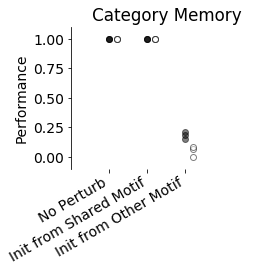

In [18]:
fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

for rnn_type in ['LeakyRNN']:
        for w_init in ['diag','randgauss']:#
            for seed in ['0','1','2']:
                if (activation=='tanh') & (rnn_type=='LeakyRNN'):
                    w_rec_coeff  = 1
                    lr = -8
                else:
                    w_rec_coeff  = 8/10
                    lr = -6

                if w_init=='diag':
                    c = 'k'
                    x_off = 0
                else:
                    c = 'w'
                    x_off = 0.2

                net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)
                net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                dir_specific_all = os.path.join('final1',ruleset,rnn_type,activation,
                    w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2)

                m = os.path.join(p,'data','rnn','multitask',net,dir_specific_all,str(seed))
        
                for key_i in range(len(p_ins.keys())):
                    key = p_ins.keys()[key_i]
                    perf = init_from_other_task(m,p_ins[key]['ri_set'],p_ins[key]['init'])

                    plt.plot(p_ins[key]['id']+x_off,np.mean(perf),'ok',markerfacecolor = c,alpha = .5)


plt.ylabel('Performance')
tit = 'Category Memory'
plt.title(tit)
plt.xticks(range(len(p_ins.keys())),['No Perturb','Init from Shared Motif','Init from Other Motif'],
           rotation = 30,ha = 'right')
plt.ylim([-.1,1.1])
plt.xlim([-1,len(p_ins.keys())+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig_spec_fldr = os.path.join(figpath,'Init_X_motifs')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = tit   
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.png'))